# SatCen Change Detection using SNAP and Sentinel-1 data

## <a name="quicklink">Quick link

* [Objective](#objective)
* [Data](#data)
* [Workflow](#workflow)
* [License](#license)

## <a name="objective">Objective 

This notebook produces a Change Detection analysis using the Sentinel Application Platform (SNAP) and Sentinel-1 Level-1 Ground Range Detected and publishes the results as a Research Object available on the SatCen VRE.

## <a name="data">Data

SENTINEL data products are made available systematically and free of charge to all data users including the general public, scientific and commercial users. Radar data will be delivered within an hour of reception for Near Real-Time (NRT) emergency response, within three hours for NRT priority areas and within 24 hours for systematically archived data.

All data products are distributed in the SENTINEL Standard Archive Format for Europe (SAFE) format.

Sentinel-1 data products are available in single polarisation (VV or HH) for Wave mode and dual polarisation (VV+VH or HH+HV) and single polarisation (HH or VV) for SM, IW and EW modes.

Level-1 Ground Range Detected (GRD) products consist of focused SAR data that has been detected, multi-looked and projected to ground range using an Earth ellipsoid model. Phase information is lost. The resulting product has approximately square resolution pixels and square pixel spacing with reduced speckle at the cost of reduced geometric resolution.

GRD products can be in one of three resolutions:

* Full Resolution (FR)
* High Resolution (HR)
* Medium Resolution (MR).

The resolution is dependent upon the amount of multi-looking performed. Level-1 GRD products are available in MR and HR for IW and EW modes, MR for WV mode and MR, HR and FR for SM mode.

## <a name="workflow">Workflow

#### Set the parameters

In [1]:
aoi_wkt = 'POLYGON((-3.611068725585937 40.57602136929037,-3.611068725585937 40.42669550575275,-3.4047317504882812 40.42669550575275,-3.4047317504882812 40.57602136929037,-3.611068725585937 40.57602136929037))'

In [2]:
polarization = 'VH'

In [3]:
data_path = '/workspace/data'

In [4]:
slave_identifier = 'S1A_IW_GRDH_1SDV_20180312T061753_20180312T061818_020978_024034_457D'

In [5]:
master_identifier = 'S1A_IW_GRDH_1SDV_20180216T061753_20180216T061818_020628_02351B_9F18'

#### Import the python packages

In [6]:
import owslib
from owslib.wps import monitorExecution
import uuid
from owslib.wps import WebProcessingService
import sys
import os
sys.path.append('/opt/anaconda/bin/')
import lxml.etree as etree
os.environ["TMPDIR"] = '1'
os.environ["_CIOP_APPLICATION_PATH"] = '/'
import requests
import cioppy
ciop = cioppy.Cioppy()
import shapely
import dateutil.parser
from shapely.wkt import loads 
import pandas as pd
import geopandas as gp
from datetime import datetime, timedelta
from io import BytesIO
from zipfile import ZipFile
%matplotlib inline
import matplotlib.pyplot as plt
import gdal
import numpy as np
import snappy
import gc
import json
sys.path.append(os.getcwd())
import ro4eo
from mimetypes import MimeTypes

%load_ext autoreload
%autoreload 2


/opt/anaconda/lib/python2.7/site-packages/cioppy/cioppy.py:31: UserWarning: The ciop_job_nodeid variable is not defined.
  warnings.warn('The ciop_job_nodeid variable is not defined.')
/opt/anaconda/lib/python2.7/site-packages/cioppy/cioppy.py:34: UserWarning: The wf_run_root variable is not defined.
  warnings.warn('The wf_run_root variable is not defined.')


#### Read the master and slave

In [7]:
slave_prd = "%s/%s/%s.SAFE/manifest.safe" % (data_path, slave_identifier, slave_identifier)
slave = snappy.ProductIO.readProduct(slave_prd)

master_prd = "%s/%s/%s.SAFE/manifest.safe" % (data_path, master_identifier, master_identifier)
master = snappy.ProductIO.readProduct(master_prd)

#### Subset master and slave

In [8]:
HashMap = snappy.jpy.get_type('java.util.HashMap')
    
snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

parameters = HashMap()

parameters.put('geoRegion', aoi_wkt)
parameters.put('subSamplingX', '1')
parameters.put('subSamplingY', '1')
parameters.put('fullSwath', 'false')
parameters.put('copyMetadata', 'true')

In [9]:
slave_subset = snappy.GPF.createProduct('Subset', parameters, slave)
master_subset = snappy.GPF.createProduct('Subset', parameters, master)

#### Apply the orbit files to the subset master and slave

In [10]:
parameters = HashMap()

parameters.put('orbitType', 'Sentinel Precise (Auto Download)')
parameters.put('polyDegree', '3')
parameters.put('continueOnFail', 'true')

In [11]:
slave_orbit_applied = snappy.GPF.createProduct('Apply-Orbit-File', parameters, slave_subset)
master_orbit_applied = snappy.GPF.createProduct('Apply-Orbit-File', parameters, master_subset)

#### Remove the thermal noise master and slave

In [12]:
parameters = HashMap()

parameters.put('removeThermalNoise', 'true')
parameters.put('reIntroduceThermalNoise', 'false')

In [13]:
slave_thermal_noise = snappy.GPF.createProduct('ThermalNoiseRemoval', parameters, slave_orbit_applied)
master_thermal_noise = snappy.GPF.createProduct('ThermalNoiseRemoval', parameters, master_orbit_applied)

#### Apply the calibration

In [14]:
parameters = HashMap()

parameters.put('auxFile', 'Product Auxiliary File')
parameters.put('outputImageInComplex','false')
parameters.put('outputImageScaleInDb','false')
parameters.put('createGammaBand', 'false')
parameters.put('createBetaBand', 'false')
parameters.put('selectedPolarisations','')
parameters.put('outputSigmaBand', 'true')
parameters.put('outputGammaBand', 'false')
parameters.put('outputBetaBand', 'false')              

In [15]:
slave_calibrated = snappy.GPF.createProduct('Calibration', parameters, slave_thermal_noise)
master_calibrated = snappy.GPF.createProduct('Calibration', parameters, master_thermal_noise)

#### Terrain Correction

In [16]:
parameters = HashMap()

parameters.put('demName', 'SRTM 3Sec')
parameters.put('externalDEMFile', '')
parameters.put('externalDEMNoDataValue', '0.0')
parameters.put('externalDEMApplyEGM', 'true')
parameters.put('demResamplingMethod', 'BILINEAR_INTERPOLATION')
parameters.put('imgResamplingMethod', 'BILINEAR_INTERPOLATION')
parameters.put('pixelSpacingInMeter', '10.0')
#parameters.put('pixelSpacingInDegree', '8.983152841195215E-5')
parameters.put('mapProjection', 'AUTO:42001')
parameters.put('nodataValueAtSea', 'true')
parameters.put('saveDEM', 'false')
parameters.put('saveLatLon', 'false')
parameters.put('saveIncidenceAngleFromEllipsoid', 'false')
parameters.put('saveProjectedLocalIncidenceAngle', 'false')
parameters.put('saveSelectedSourceBand', 'true')
parameters.put('outputComplex', 'false')
parameters.put('applyRadiometricNormalization', 'false')
parameters.put('saveSigmaNought', 'false')
parameters.put('saveGammaNought', 'false')
parameters.put('saveBetaNought', 'false')
parameters.put('incidenceAngleForSigma0', 'Use projected local incidence angle from DEM')
parameters.put('incidenceAngleForGamma0', 'Use projected local incidence angle from DEM')
parameters.put('auxFile', 'Latest Auxiliary File')



In [17]:
slave_tc = snappy.GPF.createProduct('Terrain-Correction', parameters, slave_calibrated)
master_tc = snappy.GPF.createProduct('Terrain-Correction', parameters, master_calibrated)

#### Stack the master and slave

In [18]:
parameters = HashMap()

parameters.put('resamplingType', 'BICUBIC_INTERPOLATION')
parameters.put('extent', 'Minimum')
parameters.put('initialOffsetMethod', 'Orbit')

stack = snappy.GPF.createProduct('CreateStack', parameters, [master_calibrated, slave_calibrated])



#### Apply the change detection band arithmetic expression

In [19]:
for index, band in enumerate(stack.getBandNames()):
    print band



Sigma0_VH_mst_12Mar2018
Sigma0_VV_mst_12Mar2018
Sigma0_VH_slv1_16Feb2018
Sigma0_VV_slv2_16Feb2018


In [20]:
change_detection_expression_VH = '({0} > 0.0001) && ({1} > 0.0001) && (abs(log10({0} / {1})) > 1) && ({0} > 0.05 || {1} >0.05)'.format('Sigma0_VH_mst_12Mar2018', 'Sigma0_VH_slv1_16Feb2018')
change_detection_expression_VV = '({0} > 0.0001) && ({1} > 0.0001) && (abs(log10({0} / {1})) > 1) && ({0} > 0.05 || {1} >0.05)'.format('Sigma0_VV_mst_12Mar2018', 'Sigma0_VV_slv2_16Feb2018')

In [21]:
BandDescriptor = snappy.jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')

targetBand0 = BandDescriptor()
targetBand0.name = 'change_detection_VH'
targetBand0.type = 'uint16'
targetBand0.expression = change_detection_expression_VH

targetBand1 = BandDescriptor()
targetBand1.name = 'change_detection_VV'
targetBand1.type = 'uint16'
targetBand1.expression = change_detection_expression_VV

targetBands = snappy.jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 2)
targetBands[0] = targetBand0
targetBands[1] = targetBand1

parameters = HashMap()
parameters.put('targetBands', targetBands)

change_detection = snappy.GPF.createProduct('BandMaths', parameters, stack)

In [22]:
stack = None
gc.collect()

0

#### Plot the result

In [23]:
def plotBand(product, band, vmin, vmax):
     
    band = product.getBand(band)

    w = band.getRasterWidth()
    h = band.getRasterHeight()

    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)

    band_data.shape = h, w

    imgplot = plt.imshow(band_data, cmap=plt.cm.binary_r, vmin=vmin, vmax=vmax)

    
    return imgplot 

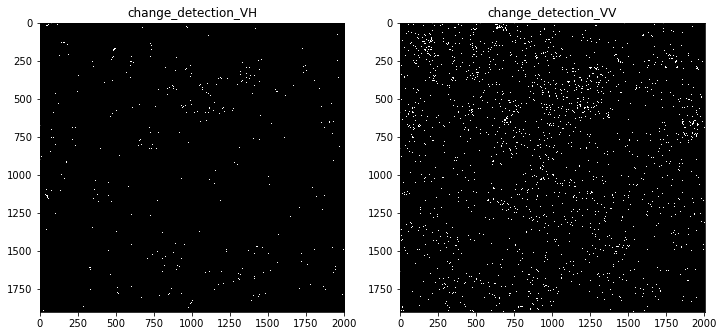

5248

In [24]:
fig = plt.figure(figsize=(20,20))

for index, band in enumerate(change_detection.getBandNames()):
        
    a=fig.add_subplot(4,4,index+1)
    imgplot = plotBand(change_detection, band, 0, 1)
    a.set_title(band)
    
plt.tight_layout()
fig = plt.gcf()
plt.show()

fig.clf()
plt.close()
gc.collect()

In [25]:
result_dir = '/workspace/EVER-EST'
if not os.path.isdir(result_dir):
    os.makedirs(result_dir)


output_name = '/workspace/EVER-EST/change_detection.tif'

snappy.ProductIO.writeProduct(change_detection, output_name, 'GeoTIFF')

#### Create the Research Object

Get an EVER-EST Single-Sign-On token from https://sso.everest.psnc.pl/authenticationendpoint/getTokenLogin.html 


In [26]:
token = '7b373d9f-be6e-3ea4-99d3-8f0e16dbc980'

In [27]:
ro_title = 'SatCen Change Detection over Madrid'
ro_description = 'This is the result of the SatCen Change Detection service of the EVER-EST VRC for Land Monitoring'
ro_vrc = 'SatCen'
master = 'https://catalog.terradue.com/sentinel1/search?format=atom&uid=%s' % master_identifier
slave = 'https://catalog.terradue.com/sentinel1/search?format=atom&uid=%s' % slave_identifier

In [28]:
sys.path.append(os.getcwd())
import ro4eo

In [29]:
roeo = ro4eo.EOResearchObject(access_token=token,
                       title=ro_title,
                       description=ro_description,
                       vrc=ro_vrc,
                       aoi=aoi_wkt)

In [30]:
roeo.isTokenValid()

False

In [31]:
roeo.add_resource(master)
roeo.add_resource(slave)
roeo.add_result(output_name)

In [32]:
ro = roeo.publish()

ConnectionError: Expected status code 201, but got 400

In [ ]:
ro

## <a name="license">License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.